<a href="https://colab.research.google.com/github/srnarasim/datagen/blob/main/SyntheticDataGeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Synthetic Data Generation using SDV for Retail Dataset

This is an experimentation to generate realistic synthetic data from a relational model.
In this experiment the Dunnhumby retail dataset is being used as a seed data to create retail dataset sythentically using [SDV - Sythentic Data Vault](https://sdv.dev/)

There are four steps involved here
1.   Organize, download sample dataset, perform simple dataprep/cleanup
2.   Specify Structure - Provide the structure of the data, Identify tables, ID and relationships
3.   Learn - Use SDV to train a [Hierarchical Modeling Algorithm](https://sdv.dev/SDV/user_guides/relational/hma1.html#what-is-hma1) based model given the structure and sample data
4.   Synthesize - Generate Data from the model.
5.   Evaluate - Compare the generated data with the real data


# Organize

In [ ]:
!pip install sdv
!pip install numpy==1.20
!pip install -q kaggle

Upload your kaggle.json file with your API Key. This is needed to download a sample retail dataset from Kaggle competition [Dunnhumby - The complete journey](https://www.kaggle.com/frtgnn/dunnhumby-the-complete-journey)

In [ ]:
from google.colab import files
files.upload()

In [ ]:
 ! mkdir ~/.kaggle
 ! cp kaggle.json ~/.kaggle/
 ! chmod 600 ~/.kaggle/kaggle.json


In [ ]:
 !mkdir data
 !kaggle datasets download -d frtgnn/dunnhumby-the-complete-journey --unzip -p data

In [ ]:
import pandas as pd
product_df = pd.read_csv("data/product.csv")
product_df = product_df.sample( frac = 0.25)
product_df = product_df.drop('COMMODITY_DESC', 1)
product_df = product_df.drop('SUB_COMMODITY_DESC', 1)
product_df = product_df.drop('CURR_SIZE_OF_PRODUCT', 1)
product_df = product_df.drop('MANUFACTURER', 1)
product_df

,PRODUCT_ID,DEPARTMENT,BRAND
65678,9301706,NUTRITION,National
67851,9545553,GROCERY,National
20146,944256,GROCERY,National
65135,9245346,DRUG GM,National
62342,8069125,DRUG GM,National
...,...,...,...
86540,15507909,FLORAL,National
18910,933705,DRUG GM,National
2485,128794,GROCERY,National
14680,897120,GROCERY,Private


In [ ]:
transaction_df = pd.read_csv("data/transaction_data.csv")
transaction_df = transaction_df.drop('COUPON_DISC', 1)
transaction_df = transaction_df.sample( frac = 0.25 )
transaction_df = transaction_df.drop('RETAIL_DISC', 1)
transaction_df = transaction_df.drop('COUPON_MATCH_DISC', 1)
transaction_df = transaction_df.drop('DAY', 1)
transaction_df = transaction_df.drop('WEEK_NO', 1)
transaction_df = transaction_df.drop('STORE_ID', 1)
transaction_df

,household_key,BASKET_ID,PRODUCT_ID,QUANTITY,SALES_VALUE,TRANS_TIME
643922,2208,30241129859,888557,1,3.19,2122
460217,934,29353505787,1051283,1,2.50,1127
1036506,2296,31833570921,973861,2,1.00,1305
661881,1602,30530928076,951594,2,5.98,2146
1176270,1848,32259725084,1054123,1,0.99,1934
...,...,...,...,...,...,...
446041,317,29311872450,1002735,1,3.69,1842
876968,1995,31242625271,911675,1,1.89,1016
1118200,1393,32090957689,1062128,2,7.98,2156
558051,143,30033390555,7409789,1,1.50,1124


In [ ]:
hh_demographic_df = pd.read_csv("data/hh_demographic.csv")
hh_demographic_df = hh_demographic_df.sample( frac = 0.25 )
hh_demographic_df

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
136,65+,B,25-34K,Unknown,Single Female,1,None/Unknown,391
37,25-34,B,Under 15K,Homeowner,1 Adult Kids,3,2,105
192,55-64,A,35-49K,Homeowner,Single Male,2,None/Unknown,576
248,65+,U,50-74K,Homeowner,2 Adults Kids,3,1,741
464,25-34,A,15-24K,Homeowner,1 Adult Kids,3,1,1437
...,...,...,...,...,...,...,...,...
351,25-34,U,35-49K,Unknown,Single Male,1,None/Unknown,1041
178,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,526
302,45-54,U,150-174K,Unknown,Single Male,1,None/Unknown,895
718,45-54,U,50-74K,Homeowner,Single Female,1,None/Unknown,2237


# Organize

In [ ]:
real_data = {}
real_data["product"] = product_df
real_data["transaction_data"] = transaction_df
real_data["hh_demographic"] = hh_demographic_df

In [ ]:
from sdv.utils import display_tables
display_tables(real_data)

product,transaction_data,hh_demographic
PRODUCT_ID,DEPARTMENT,BRAND
9301706,NUTRITION,National
9545553,GROCERY,National
944256,GROCERY,National
9245346,DRUG GM,National
8069125,DRUG GM,National
9487644,DRUG GM,National
6554314,DRUG GM,National
1125702,GROCERY,National
1017072,DRUG GM,National


In [ ]:
metadata_json = {
   "tables":{
      "product":{
         "primary_key":"PRODUCT_ID",
         "fields":{
            "PRODUCT_ID":{
               "type":"id",
               "subtype":"integer"
            },
            "DEPARTMENT":{
               "type":"categorical"
            },
            "BRAND":{
               "type":"categorical"
            }
         }
      },
      "transaction_data":{
         "primary_key":"BASKET_ID",
         "fields":{
            "household_key":{
              "ref":{
                "field":"household_key",
                "table":"hh_demographic"
              },
               "type":"id",
               "subtype":"integer"
            },
            "BASKET_ID":{
               "type":"id",
               "subtype":"integer"
            },
            "PRODUCT_ID":{
               "ref":{
                  "field":"PRODUCT_ID",
                  "table":"product"
               },
               "type":"id",
               "subtype":"integer"
            },
            "QUANTITY":{
               "type":"numerical",
               "subtype":"integer"
            },
            "SALES_VALUE":{
               "type":"numerical",
               "subtype":"float"
            },
            "TRANS_TIME":{
               "type":"numerical",
               "subtype":"integer"
            }
         }
      },
      "hh_demographic":{
        "primary_key":"household_key",
        "fields":{
          "household_key":{
            "type":"id",
            "subtype":"integer"
          },
          "AGE_DESC":{
            "type":"categorical"
          },
          "MARITAL_STATUS_CODE":{
            "type":"categorical"
          },
          "INCOME_DESC":{
            "type":"categorical"
          },
          "HOMEOWNER_DESC":{
            "type":"categorical"
          },
          "HH_COMP_DESC":{
            "type":"categorical"
          },
          "HOUSEHOLD_SIZE_DESC":{
            "type":"categorical"
          },
          "KID_CATEGORY_DESC":{
            "type":"categorical"
          }
        }
      }
   }
}

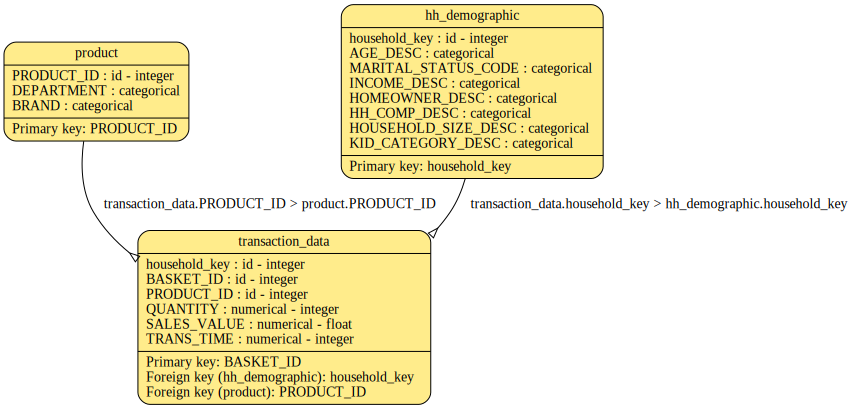

In [ ]:
from sdv import Metadata
metadata = Metadata(metadata_json)
metadata.visualize()

# Learn

In [ ]:
from sdv.relational import HMA1
model = HMA1(metadata)
model.fit(real_data)

In [ ]:
model.save('my_model.pkl')

# Synthesize

In [ ]:
model = HMA1.load('my_model.pkl')

In [ ]:
synthetic_data = model.sample( num_rows=100)

In [ ]:
display_tables(synthetic_data)

product,transaction_data,hh_demographic
PRODUCT_ID,DEPARTMENT,BRAND
0,GROCERY,National
1,DRUG GM,National
2,DRUG GM,National
3,DRUG GM,National
4,DRUG GM,National
5,PASTRY,National
6,GROCERY,National
7,DRUG GM,National
8,GROCERY,National


# Evaluate

In [ ]:
from sdv.metrics.relational import KSTestExtended
KSTestExtended.compute(real_data, synthetic_data)

0.6153769246164859

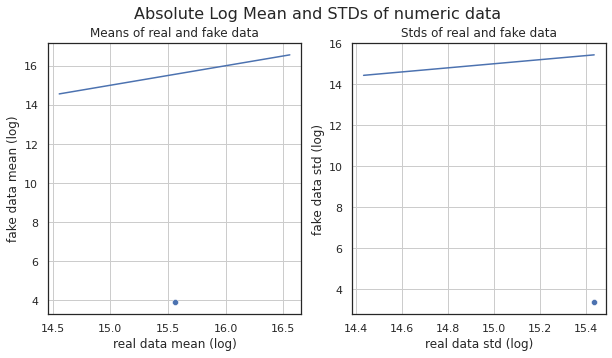

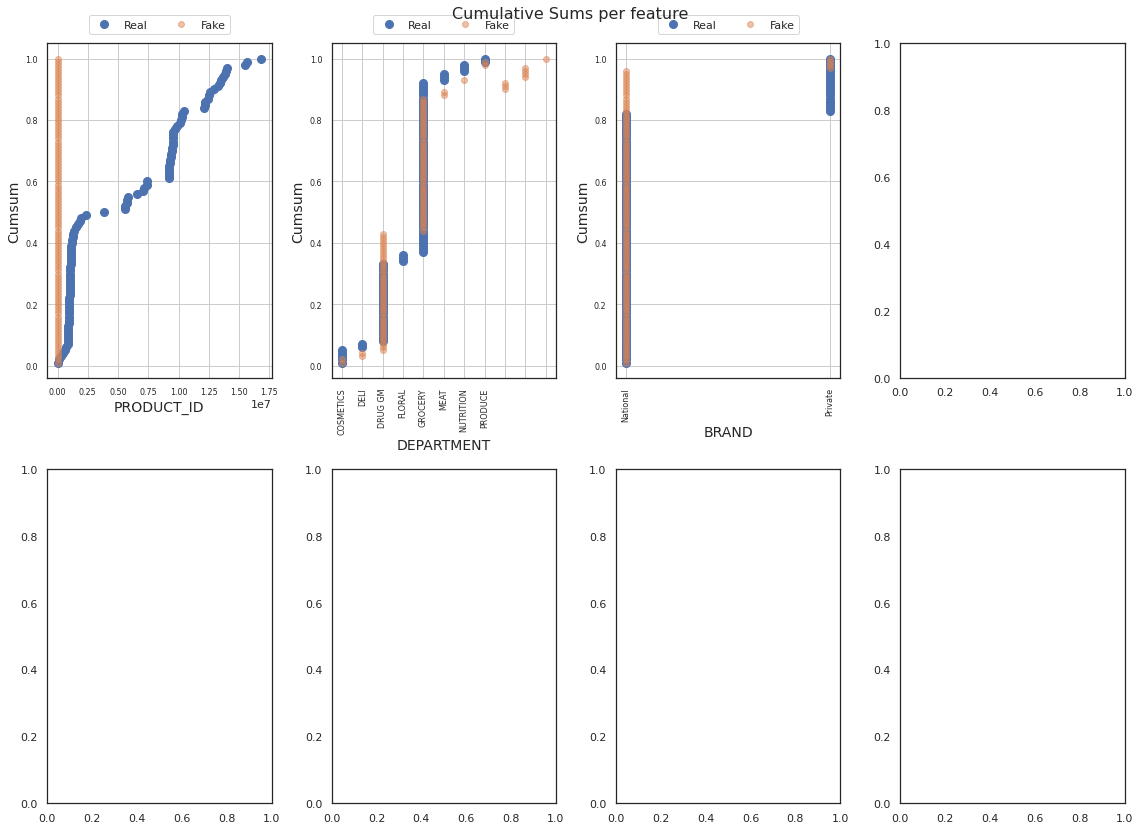

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


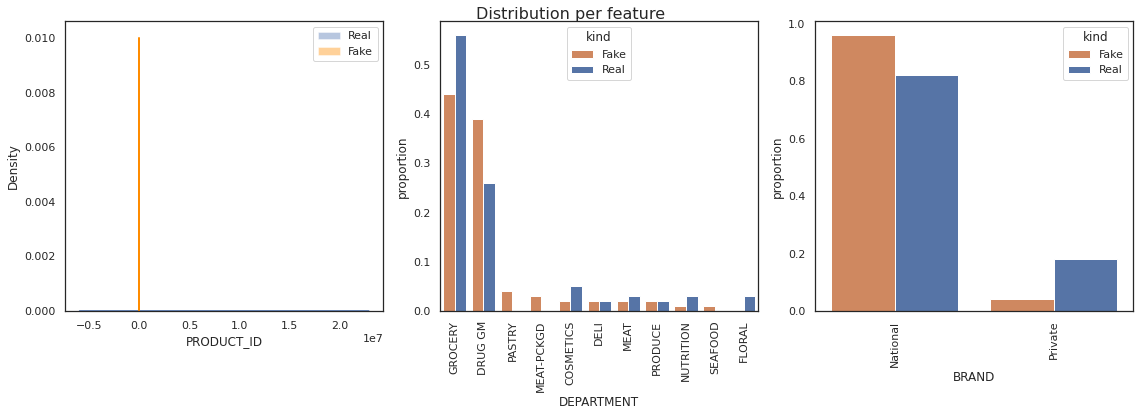

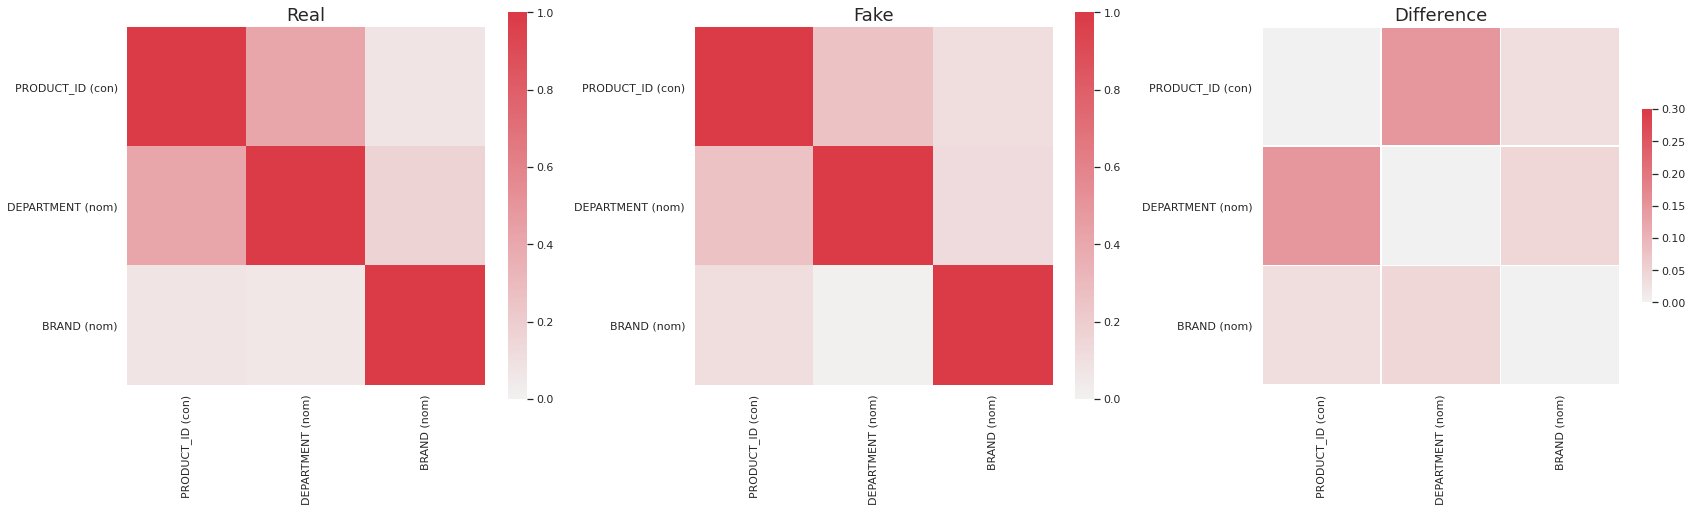

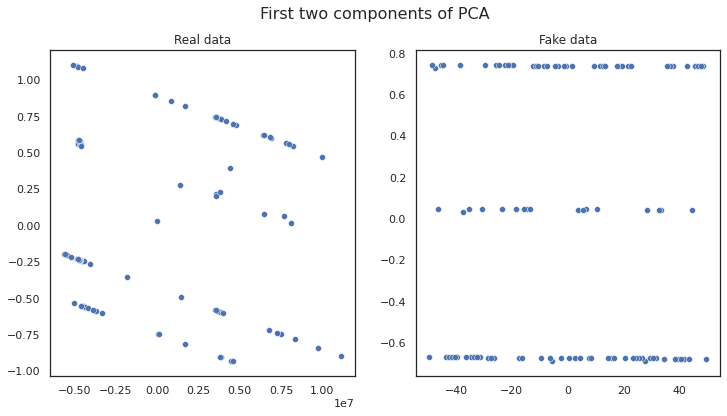

In [ ]:
from table_evaluator import load_data, TableEvaluator
category_columns = ["DEPARTMENT", "BRAND"]
table_evaluator =  TableEvaluator(real_data["product"], synthetic_data["product"], cat_cols = category_columns )
table_evaluator.visual_evaluation()

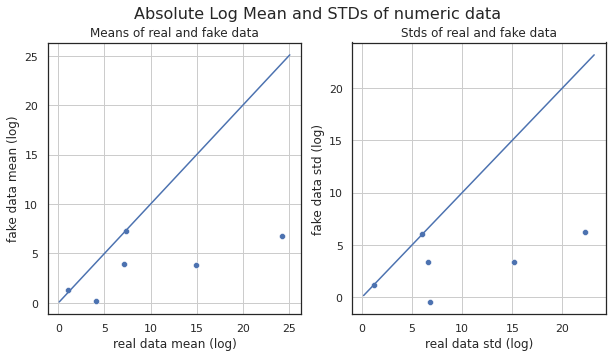

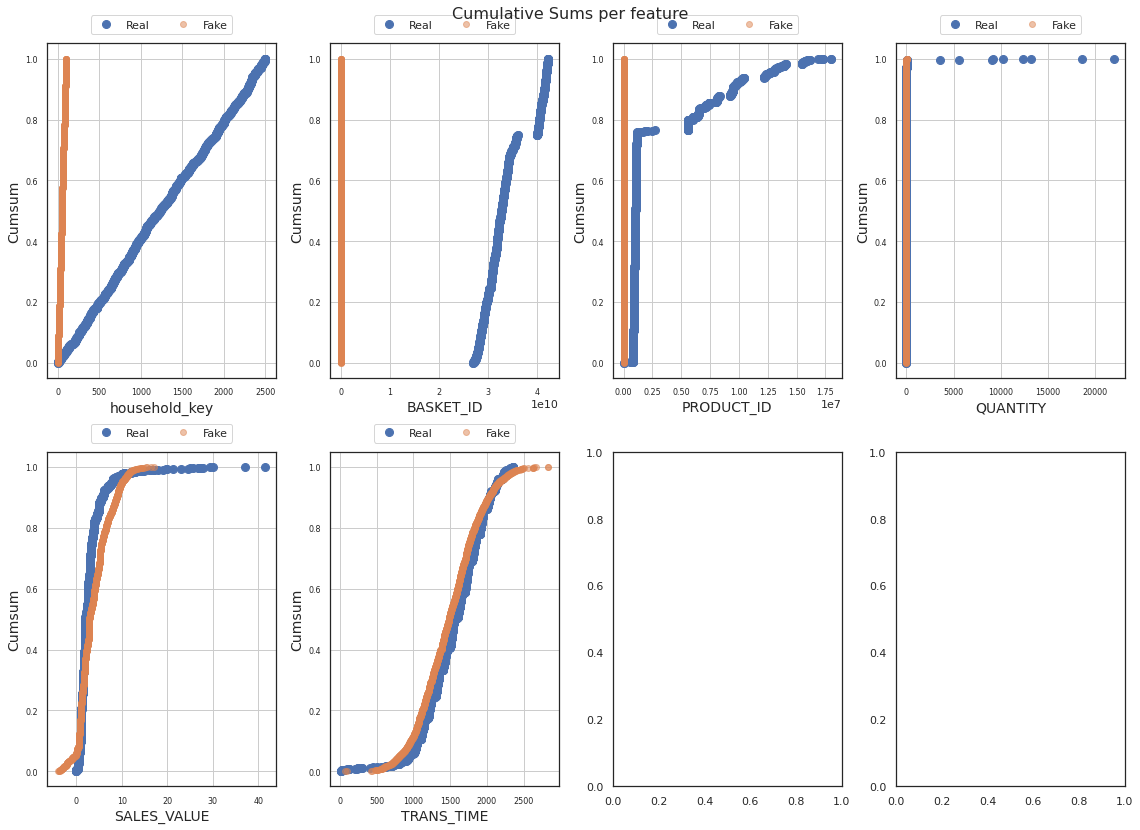

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

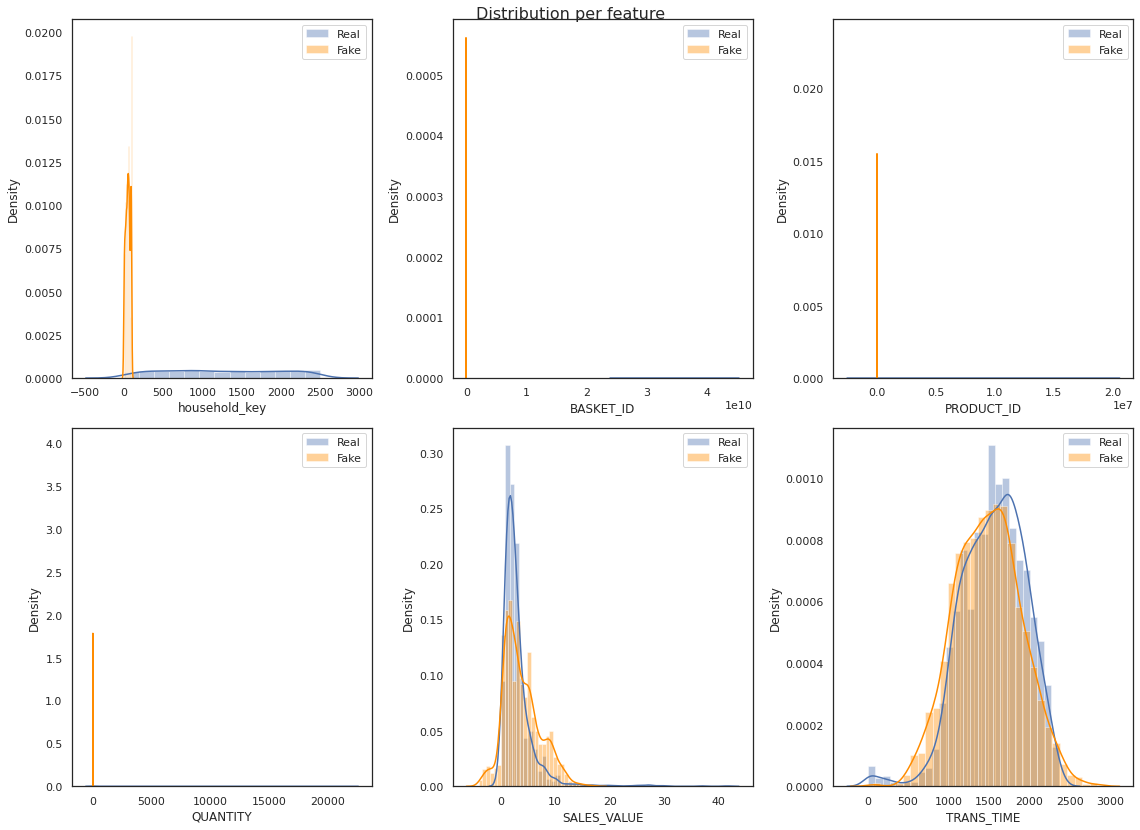

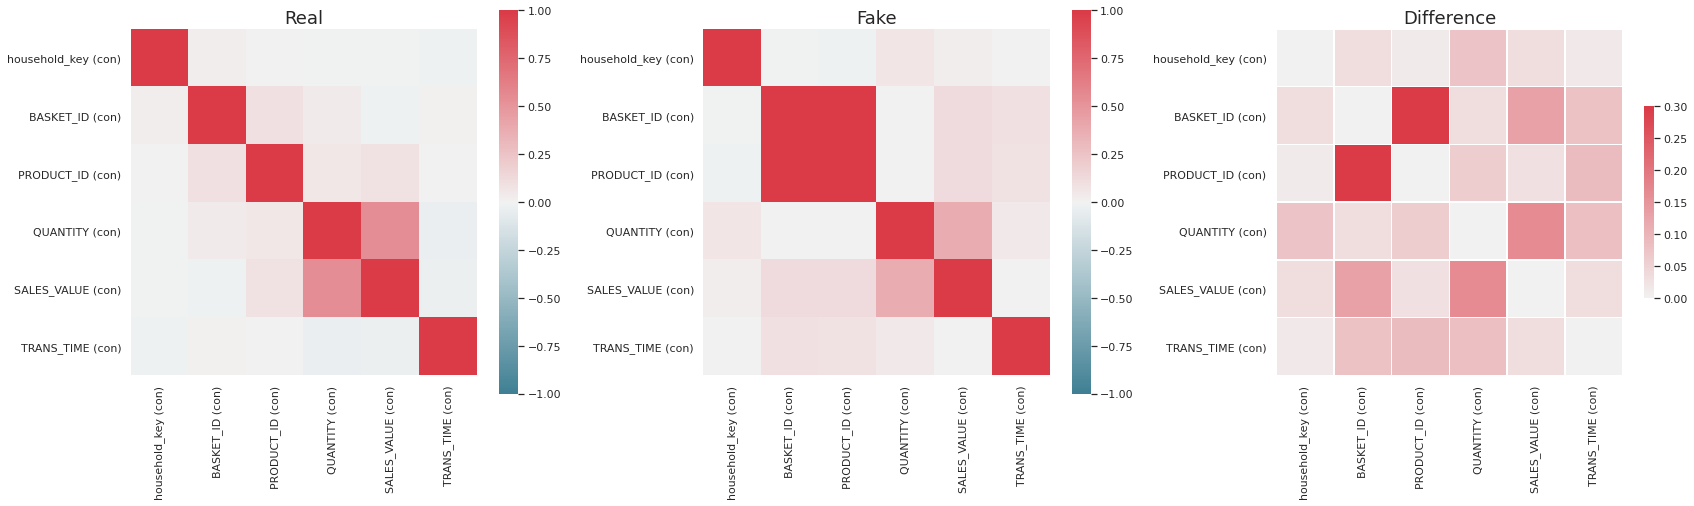

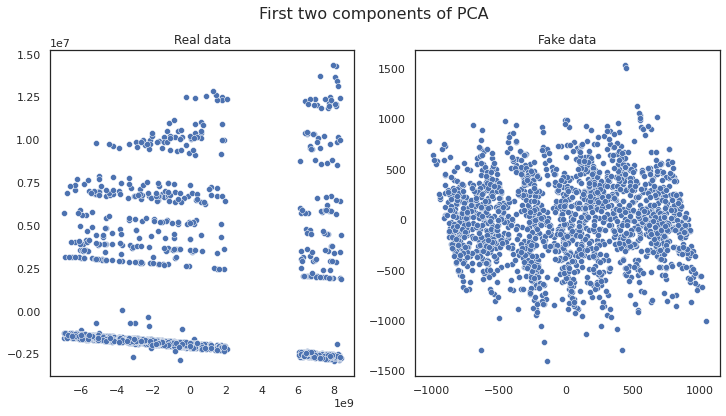

In [ ]:
category_columns = []
TableEvaluator(real_data["transaction_data"], synthetic_data["transaction_data"], cat_cols = category_columns ).visual_evaluation()

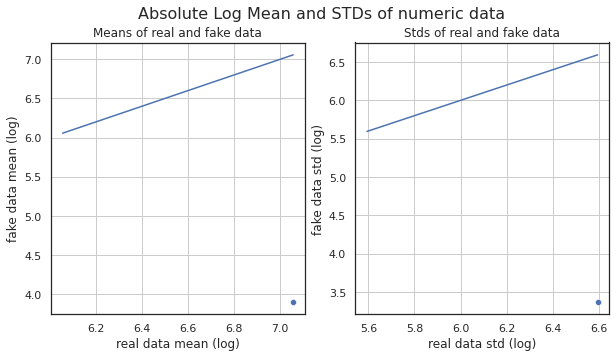

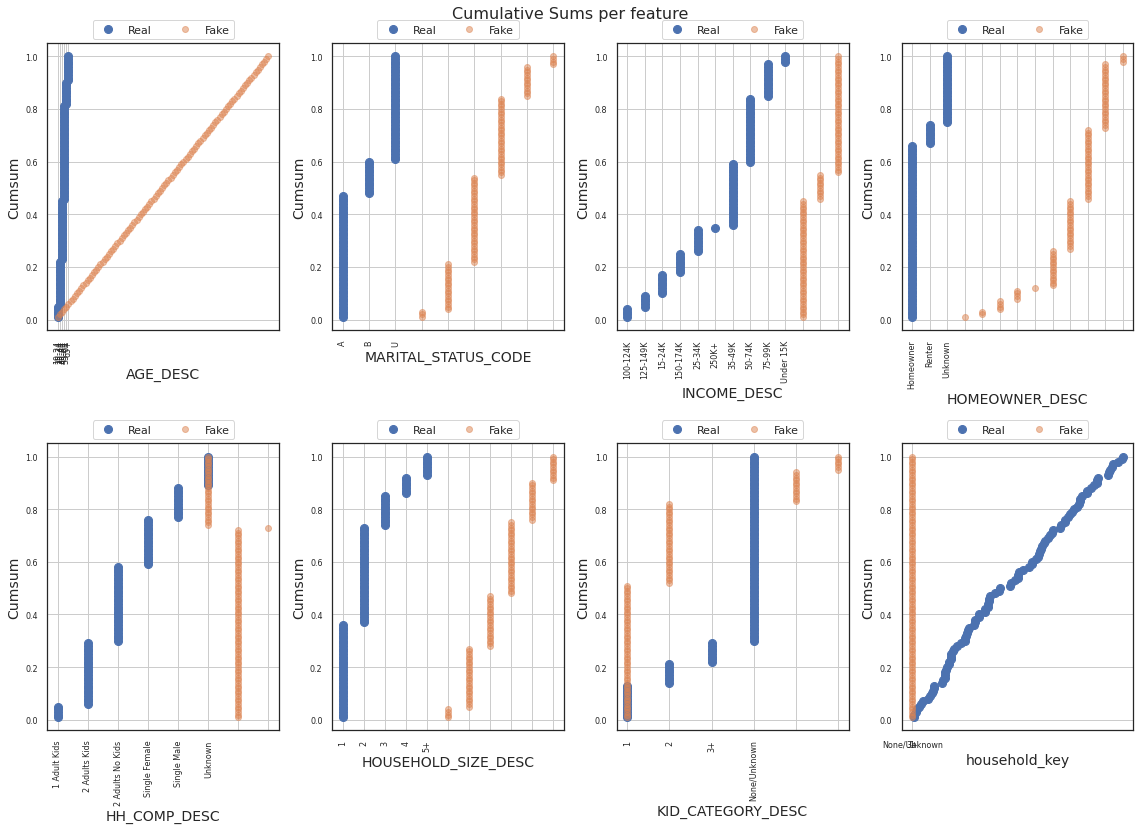

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


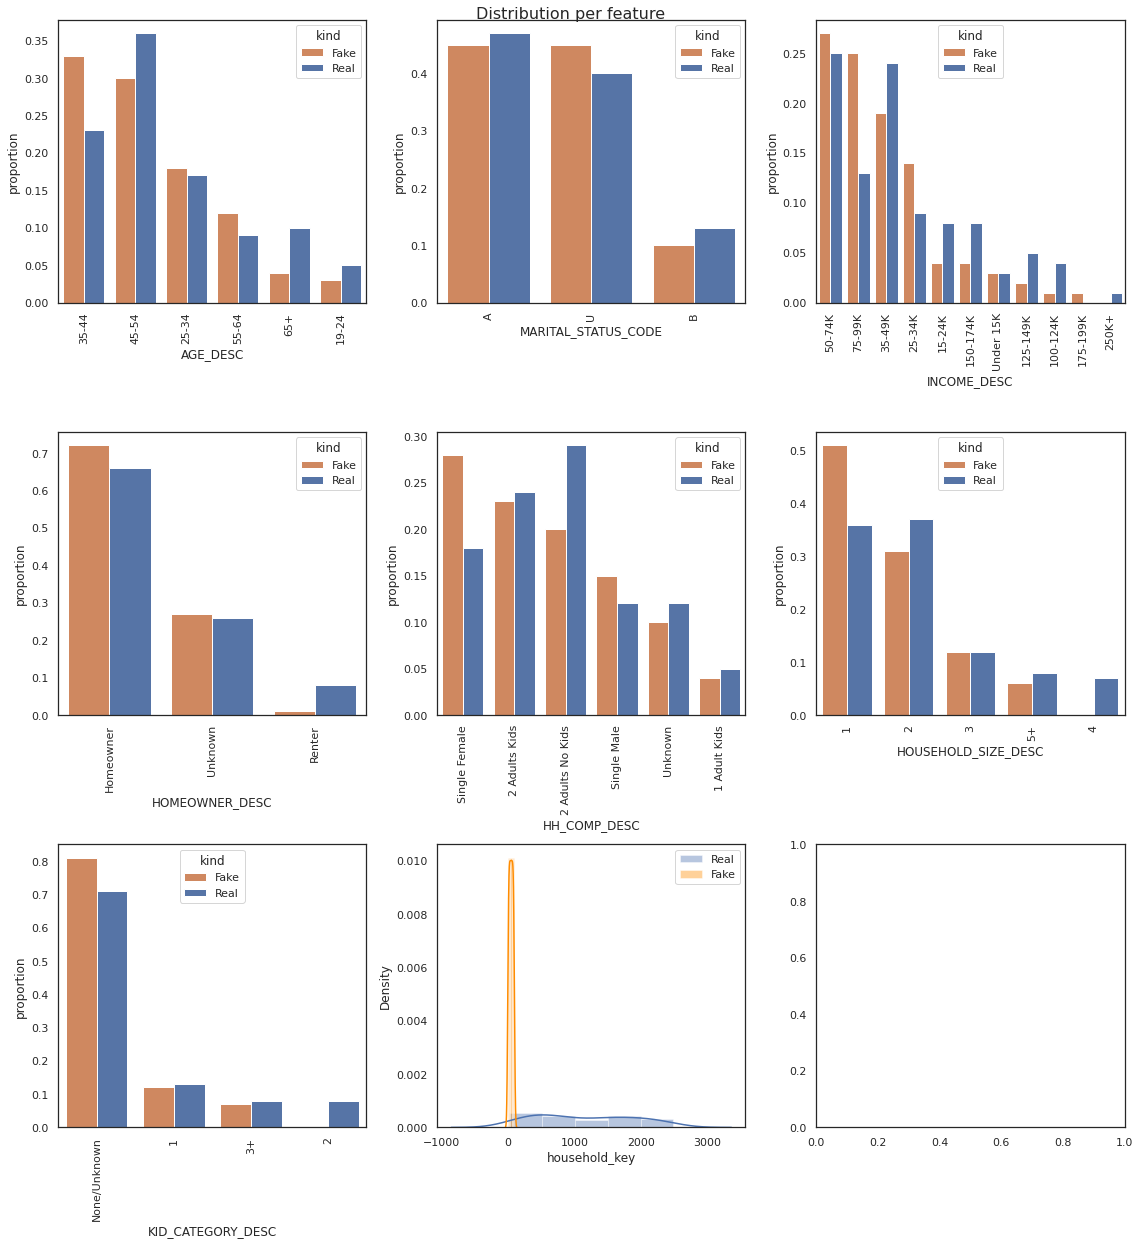

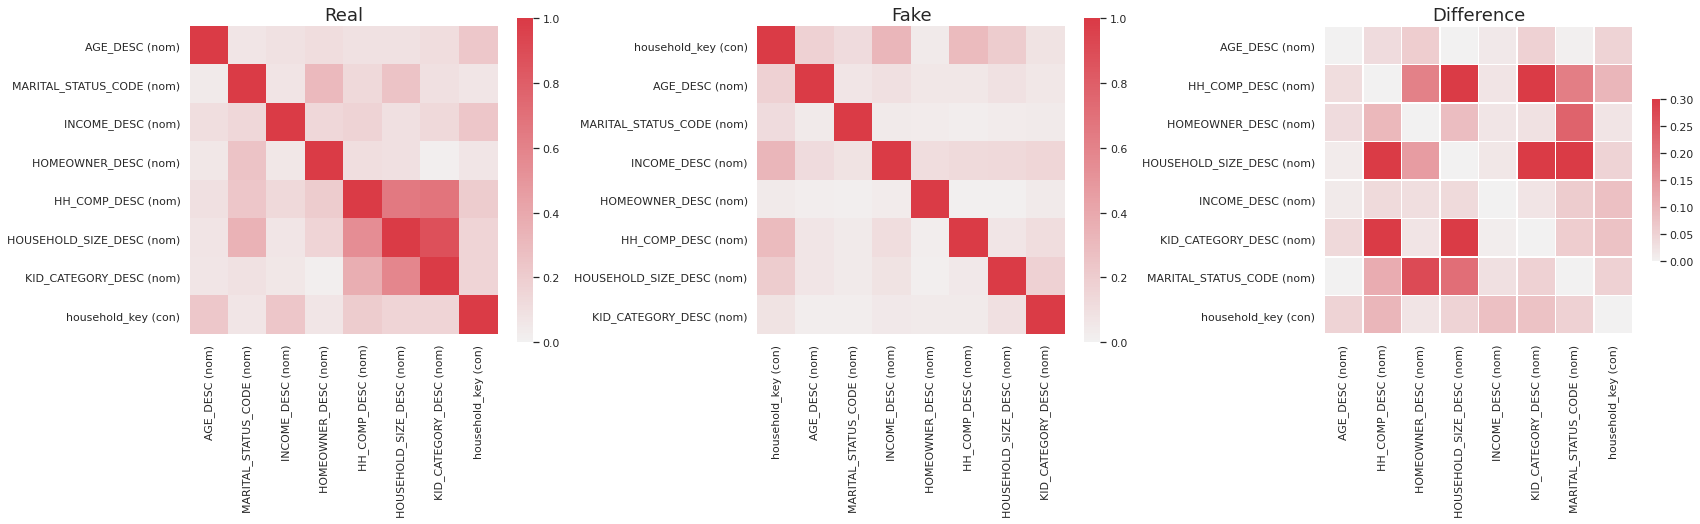

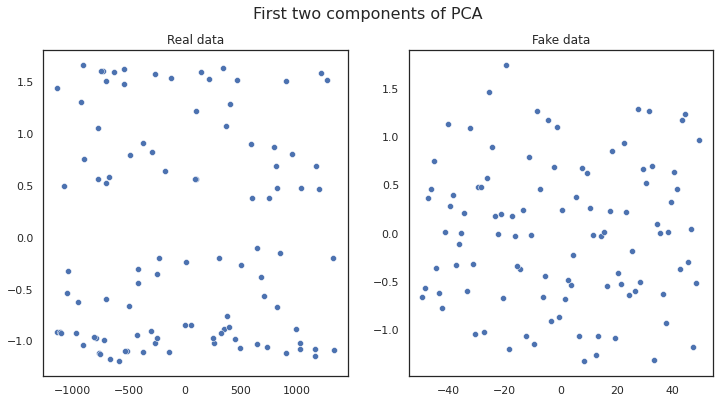

In [ ]:
category_columns = ["AGE_DESC", "MARITAL_STATUS_CODE","INCOME_DESC","HOMEOWNER_DESC","HH_COMP_DESC","HOUSEHOLD_SIZE_DESC","KID_CATEGORY_DESC"]
TableEvaluator(real_data["hh_demographic"], synthetic_data["hh_demographic"], cat_cols = category_columns ).visual_evaluation()
